In [24]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from collections import Counter

Загрузка и подготовка бинарного изображения

In [25]:
image = cv.imread('sar_1.jpg')
image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
_, monochrome_image = cv.threshold(image_gray, 128, 255, cv.THRESH_BINARY)

Сохранение монохромного изображения

In [26]:
with open('monochrome_image.txt', 'w') as file:
    for row in monochrome_image:
        line = ' '.join(str(pixel) for pixel in row)
        file.write(line + '\n')

print(f"Изображение сохранено в файл 'monochrome_image.txt', размер изображения: {monochrome_image.shape}")

Изображение сохранено в файл 'monochrome_image.txt', размер изображения: (675, 1200)


Визуализация исходных изображений

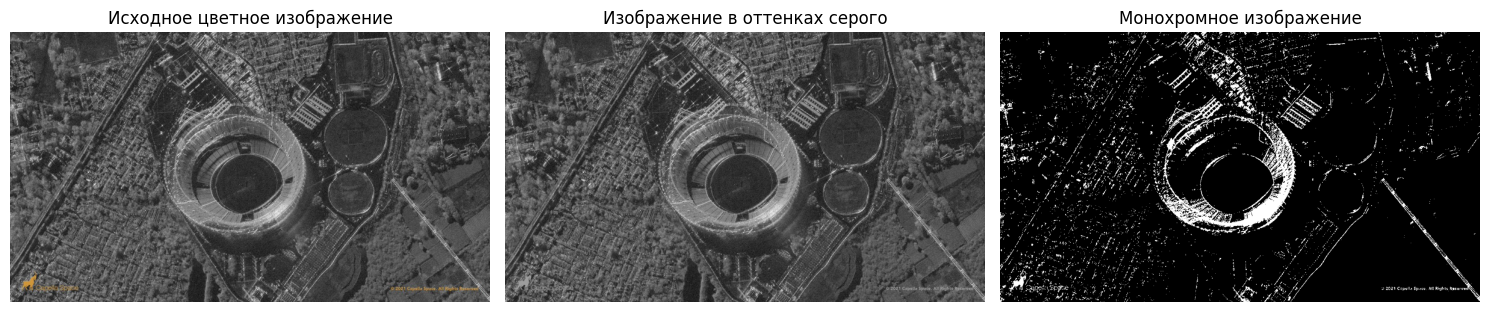

In [27]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
plt.title('Исходное цветное изображение')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(image_gray, cmap='gray')
plt.title('Изображение в оттенках серого')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(monochrome_image, cmap='gray')
plt.title('Монохромное изображение')
plt.axis('off')

plt.tight_layout()
plt.show()

Вейвлет-преобразование Хаара

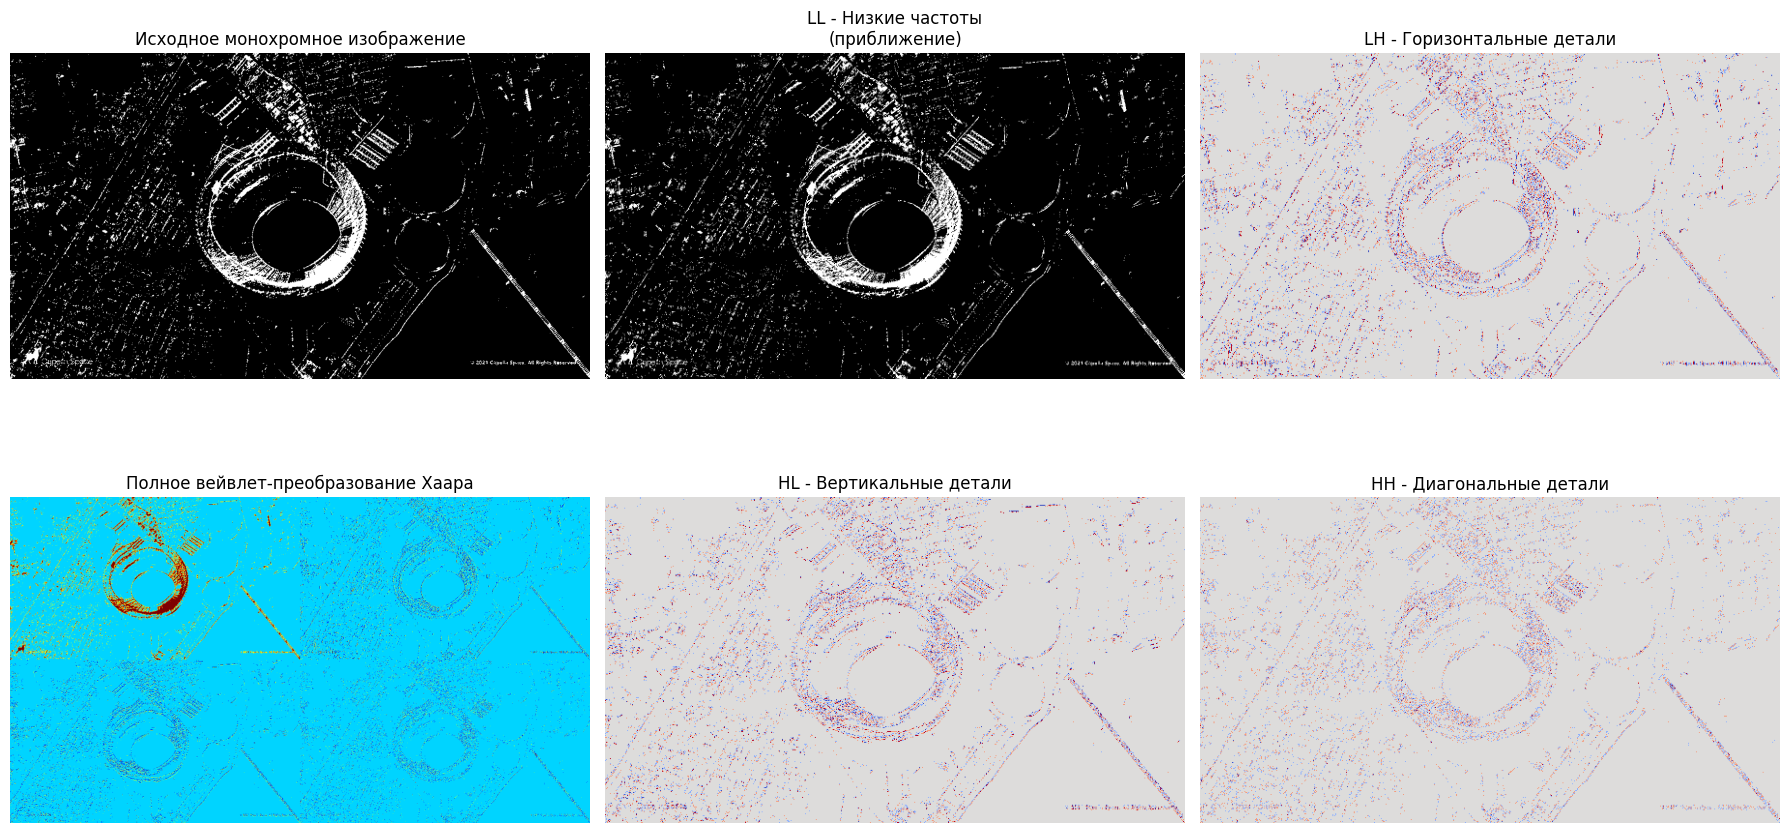

In [28]:
def haar_transform(image):
    h, w = image.shape
    h = h - h % 2
    w = w - w % 2
    image = image[:h, :w].astype(np.float32)
    
    temp = np.zeros_like(image)
    for i in range(h):
        for j in range(0, w, 2):
            temp[i, j//2] = (image[i, j] + image[i, j+1]) / 2
            temp[i, j//2 + w//2] = (image[i, j] - image[i, j+1]) / 2
    
    result = np.zeros_like(temp)
    for j in range(w):
        for i in range(0, h, 2):
            result[i//2, j] = (temp[i, j] + temp[i+1, j]) / 2
            result[i//2 + h//2, j] = (temp[i, j] - temp[i+1, j]) / 2
    
    ll = result[:h//2, :w//2]
    lh = result[:h//2, w//2:]
    hl = result[h//2:, :w//2]
    hh = result[h//2:, w//2:]
    
    return ll, lh, hl, hh, result

ll, lh, hl, hh, haar_result = haar_transform(monochrome_image)

plt.figure(figsize=(18, 10))

plt.subplot(2, 3, 1)
plt.imshow(monochrome_image, cmap='gray')
plt.title('Исходное монохромное изображение')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(haar_result, cmap='jet')
plt.title('Полное вейвлет-преобразование Хаара')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(ll, cmap='gray')
plt.title('LL - Низкие частоты\n(приближение)')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(lh, cmap='coolwarm', vmin=-128, vmax=128)
plt.title('LH - Горизонтальные детали')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(hl, cmap='coolwarm', vmin=-128, vmax=128)
plt.title('HL - Вертикальные детали')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(hh, cmap='coolwarm', vmin=-128, vmax=128)
plt.title('HH - Диагональные детали')
plt.axis('off')

plt.tight_layout()
plt.show()

Квантование высокочастотных компонент

In [29]:
def quantize_components(lh, hl, hh, n_quants=4):
    """Квантование высокочастотных компонент с нормализацией"""
    all_high_freq = np.concatenate([lh.flatten(), hl.flatten(), hh.flatten()])
    
    min_val = np.min(all_high_freq)
    max_val = np.max(all_high_freq)
    
    quant_levels = np.linspace(min_val, max_val, n_quants)
    
    def quantize_single(component):
        quantized = np.zeros_like(component, dtype=int)
        for i in range(component.shape[0]):
            for j in range(component.shape[1]):
                distances = np.abs(quant_levels - component[i, j])
                quantized[i, j] = np.argmin(distances)
        return quantized, quant_levels
    
    lh_quant, levels = quantize_single(lh)
    hl_quant, _ = quantize_single(hl)
    hh_quant, _ = quantize_single(hh)
    
    return lh_quant, hl_quant, hh_quant, levels

def dequantize_components(lh_quant, hl_quant, hh_quant, levels):
    """Обратное квантование"""
    lh_restored = levels[lh_quant]
    hl_restored = levels[hl_quant]
    hh_restored = levels[hh_quant]
    return lh_restored, hl_restored, hh_restored

lh_quant, hl_quant, hh_quant, quant_levels = quantize_components(lh, hl, hh, n_quants=4)
lh_restored, hl_restored, hh_restored = dequantize_components(lh_quant, hl_quant, hh_quant, quant_levels)

print(f"Уровни квантования: {quant_levels}")

Уровни квантования: [-127.5  -42.5   42.5  127.5]


Визуализация до и после квантования

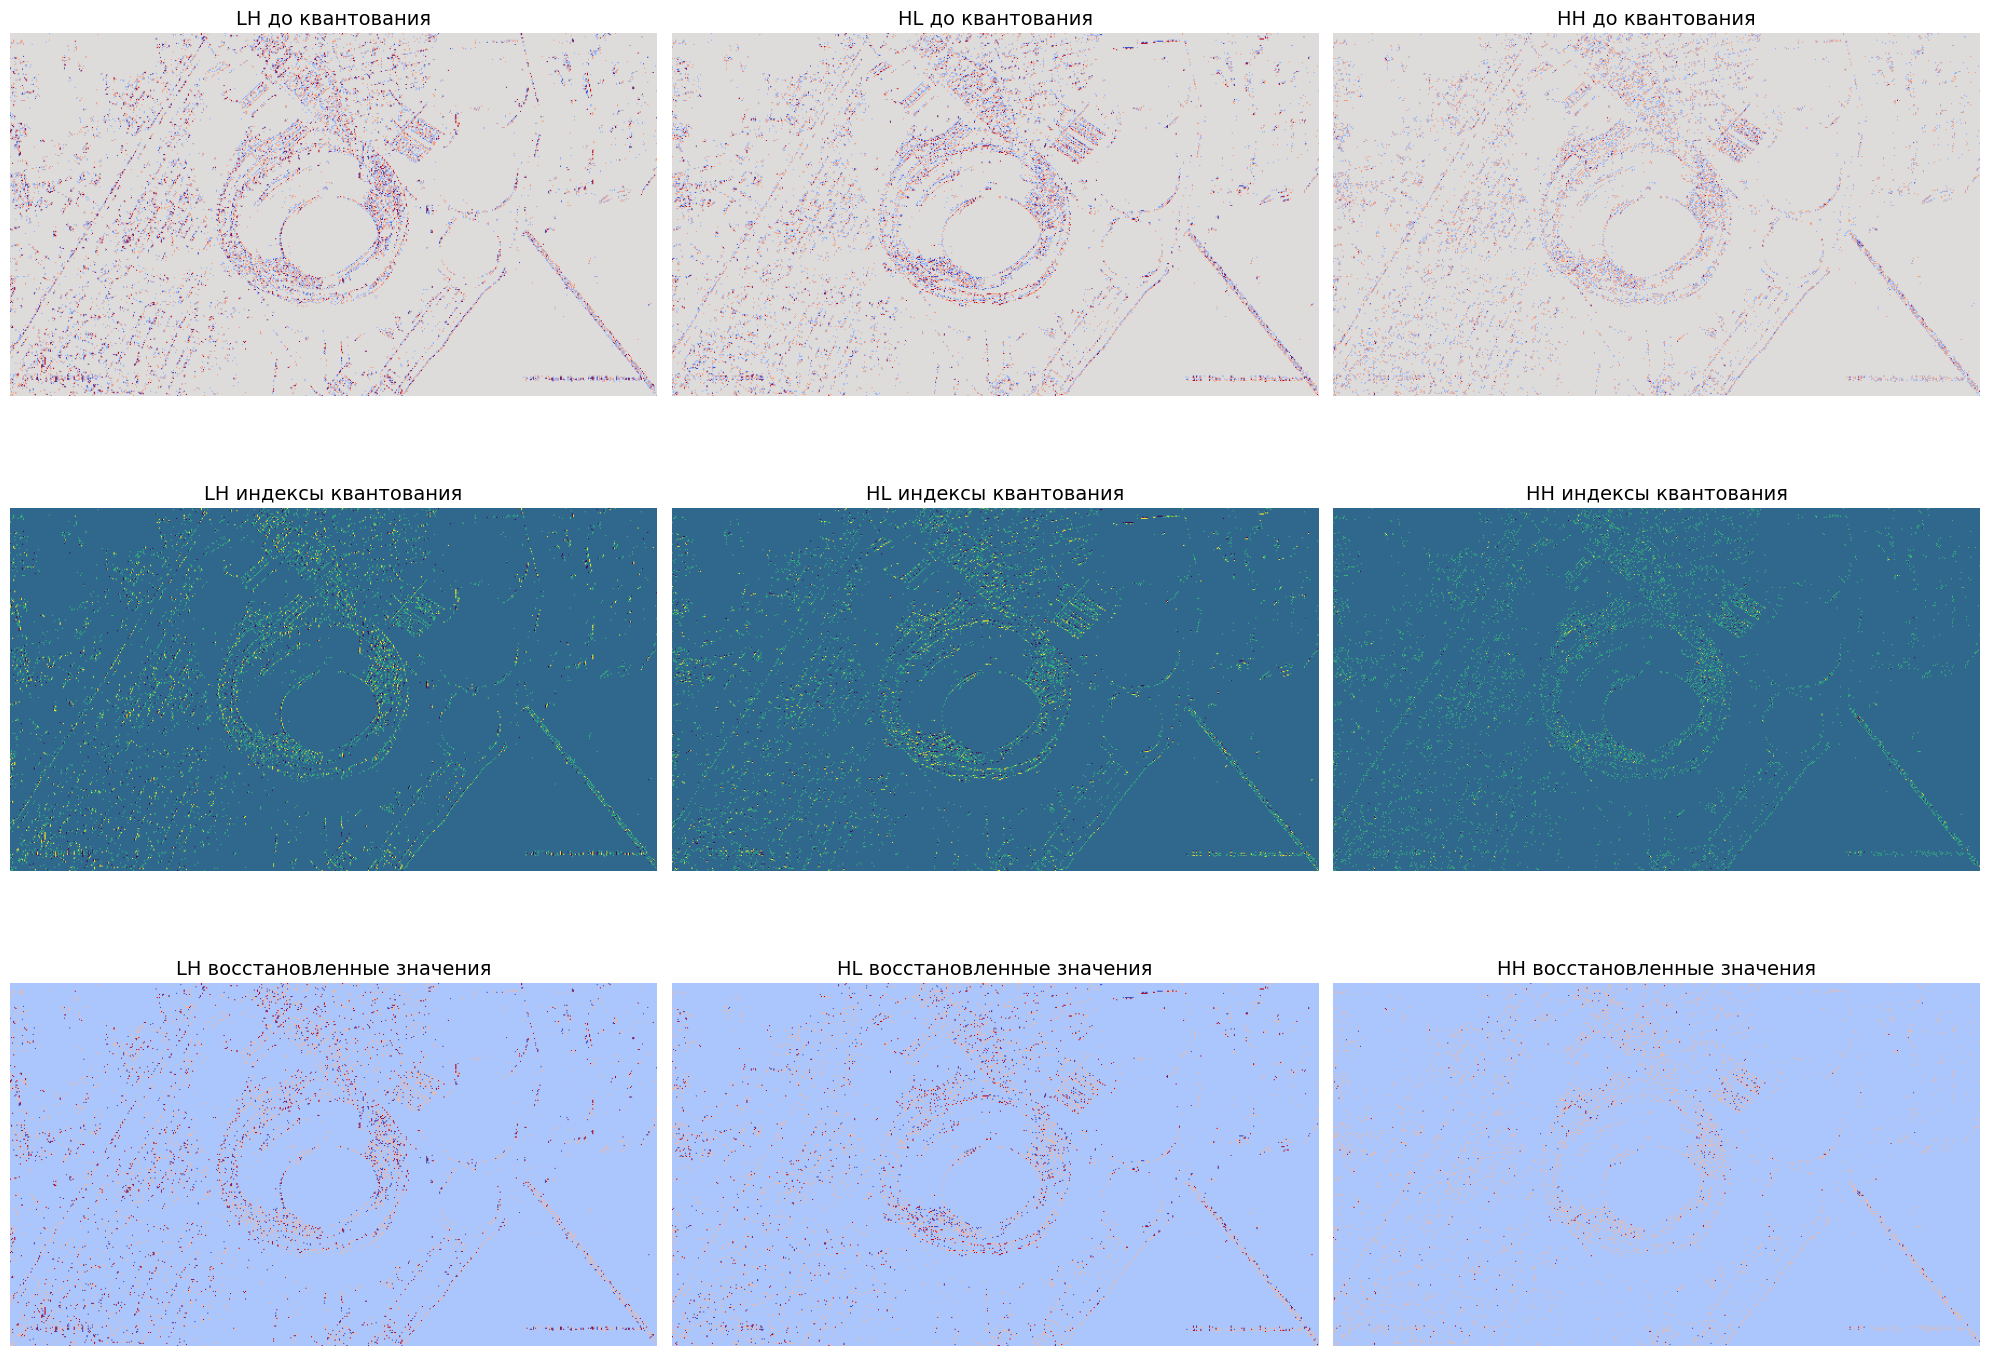

In [30]:
plt.figure(figsize=(20, 15))

plt.subplot(3, 3, 1)
plt.imshow(lh, cmap='coolwarm', vmin=-128, vmax=128)
plt.title('LH до квантования', fontsize=14)
plt.axis('off')

plt.subplot(3, 3, 2)
plt.imshow(hl, cmap='coolwarm', vmin=-128, vmax=128)
plt.title('HL до квантования', fontsize=14)
plt.axis('off')

plt.subplot(3, 3, 3)
plt.imshow(hh, cmap='coolwarm', vmin=-128, vmax=128)
plt.title('HH до квантования', fontsize=14)
plt.axis('off')

plt.subplot(3, 3, 4)
plt.imshow(lh_quant, cmap='viridis')
plt.title('LH индексы квантования', fontsize=14)
plt.axis('off')

plt.subplot(3, 3, 5)
plt.imshow(hl_quant, cmap='viridis')
plt.title('HL индексы квантования', fontsize=14)
plt.axis('off')

plt.subplot(3, 3, 6)
plt.imshow(hh_quant, cmap='viridis')
plt.title('HH индексы квантования', fontsize=14)
plt.axis('off')

plt.subplot(3, 3, 7)
plt.imshow(lh_restored, cmap='coolwarm', vmin=-128, vmax=128)
plt.title('LH восстановленные значения', fontsize=14)
plt.axis('off')

plt.subplot(3, 3, 8)
plt.imshow(hl_restored, cmap='coolwarm', vmin=-128, vmax=128)
plt.title('HL восстановленные значения', fontsize=14)
plt.axis('off')

plt.subplot(3, 3, 9)
plt.imshow(hh_restored, cmap='coolwarm', vmin=-128, vmax=128)
plt.title('HH восстановленные значения', fontsize=14)
plt.axis('off')

plt.tight_layout()
plt.show()

Кодирование и сохранение

In [31]:
def run_length_encode_improved(data):
    flattened = data.flatten()
    if len(flattened) == 0:
        return []
    
    encoded = []
    current_val = flattened[0]
    count = 1
    
    for i in range(1, len(flattened)):
        if flattened[i] == current_val and count < 255:
            count += 1
        else:
            encoded.append((int(current_val), int(count)))
            current_val = flattened[i]
            count = 1
    
    encoded.append((int(current_val), int(count)))
    return encoded

lh_rle = run_length_encode_improved(lh_quant)
hl_rle = run_length_encode_improved(hl_quant)
hh_rle = run_length_encode_improved(hh_quant)

with open('haar_compressed.txt', 'w') as file:
    file.write("LL:\n")
    np.savetxt(file, ll.astype(int), fmt='%d')
    file.write("\n")
    
    components = [('LH', lh_rle), ('HL', hl_rle), ('HH', hh_rle)]
    
    for comp_name, rle_data in components:
        file.write(f"{comp_name}:\n")
        for value, count in rle_data:
            file.write(f"{value} {count}\n")
        file.write("\n")
    
    file.write("QUANTIZATION_LEVELS:\n")
    file.write(' '.join([f"{val:.6f}" for val in quant_levels]))

print("Сжатые данные сохранены в 'haar_compressed.txt'")

with open('monochrome_image.txt', 'r') as f:
    original_size = len(f.read())

with open('haar_compressed.txt', 'r') as f:
    compressed_size = len(f.read())

print(f"\nСравнение объемов памяти:")
print(f"Исходное монохромное изображение: {original_size} байт")
print(f"После вейвлет-преобразования и сжатия: {compressed_size} байт")
print(f"Коэффициент сжатия: {original_size/compressed_size:.2f}:1")
print(f"Экономия памяти: {((original_size - compressed_size) / original_size * 100):.1f}%")

Сжатые данные сохранены в 'haar_compressed.txt'

Сравнение объемов памяти:
Исходное монохромное изображение: 1735428 байт
После вейвлет-преобразования и сжатия: 640367 байт
Коэффициент сжатия: 2.71:1
Экономия памяти: 63.1%
